In [1]:
%matplotlib widget

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import mplcursors
import IPython
import math

In [3]:
dest = '../../data/2nd Semester/images/'

In [4]:
class box:
    def __init__(self):
        self.bottom = 0
        self.top =0
        self.right = 0
        self.left = 0

    def print(self, endl=""):
        print("bottom =", self.bottom)
        print("left =", self.left)
        print("top =", self.top)
        print("right =", self.right, endl)

In [5]:
class image_data:
    def __init__(self):
        self.pixels = None
        self.__bounds = None
        self.__transform = None
        self.__real_bounds = None

    def load(self, dataset, scale):
        self.pixels = dataset.read(1).astype(float)
        self.pixels *= scale
        self.__bounds = dataset.bounds
        self.__real_bounds = box()
        self.__transform = dataset.meta['transform']
        
        self.__real_bounds.right, self.__real_bounds.top = rasterio.transform.xy(self.__transform,0 ,self.pixels.shape[1]-1)
        self.__real_bounds.left, self.__real_bounds.bottom = rasterio.transform.xy(self.__transform, self.pixels.shape[0]-1, 0)

    def getxy(self, row, col):
        if row >=0 and row < self.pixels.shape[1] and col >= 0 and col < self.pixels.shape[0]:
            return rasterio.transform.xy(self.__transform, row , col)
        else:
            print("ROW COL NOT IN BOUNDS")
            return (0,0)

    def getrowcol(self, x, y):
        return rasterio.transform.rowcol(self.__transform, x , y)

    def map(self, other_image, row, col):
        x, y = rasterio.transform.xy(self.__transform, row ,col)
        return rasterio.transform.rowcol(other_image.__transform, x , y)
    
    @property
    def size(self):
        return self.pixels.size
        
    @property
    def bounds(self):
        return self.__real_bounds


In [7]:
# loading the images
comparison = image_data()
day = image_data()
    
with rasterio.open(dest+"Greece/day.tif") as dataset:
    day.load(dataset, 0.02)

with rasterio.open(dest+"Greece/wp.tif") as dataset:
    comparison.load(dataset,1)

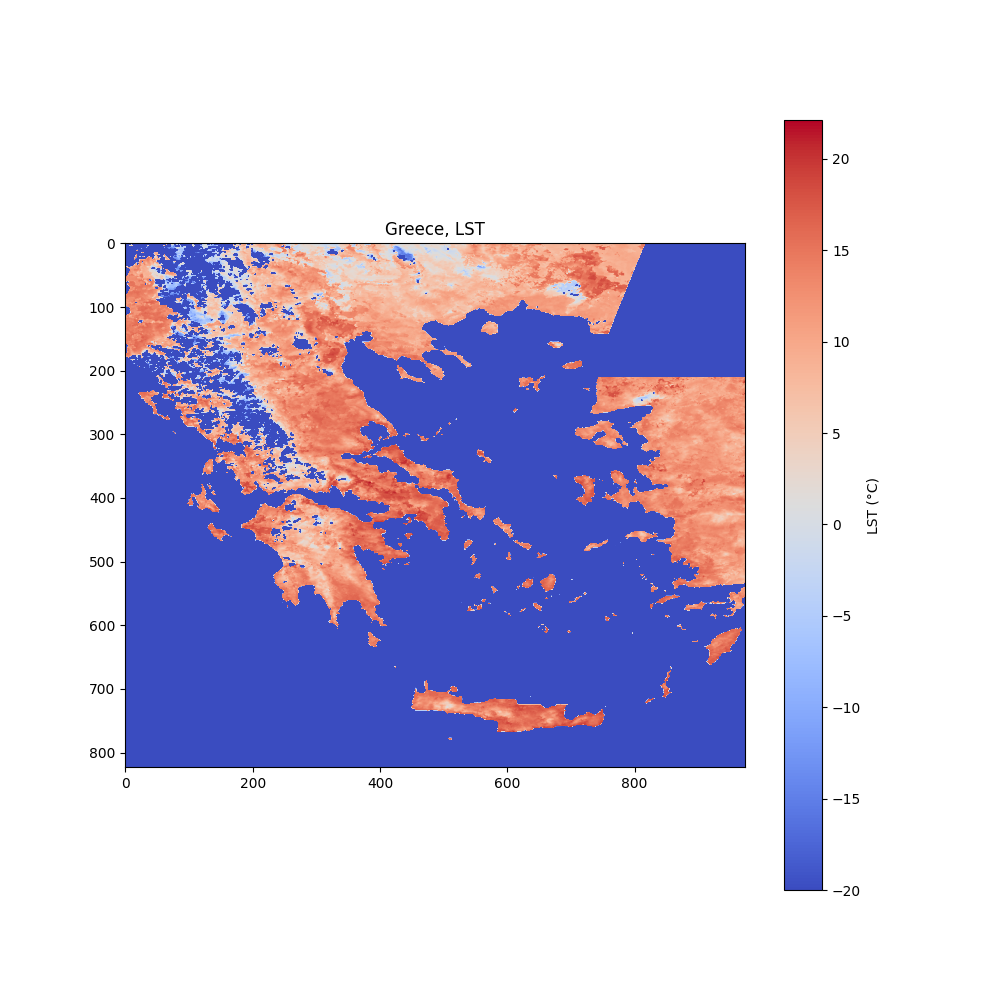

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(day.pixels-273.15, cmap='coolwarm', vmin =-20)
plt.colorbar(label='LST (°C)')
plt.title('Greece, LST')
plt.show()

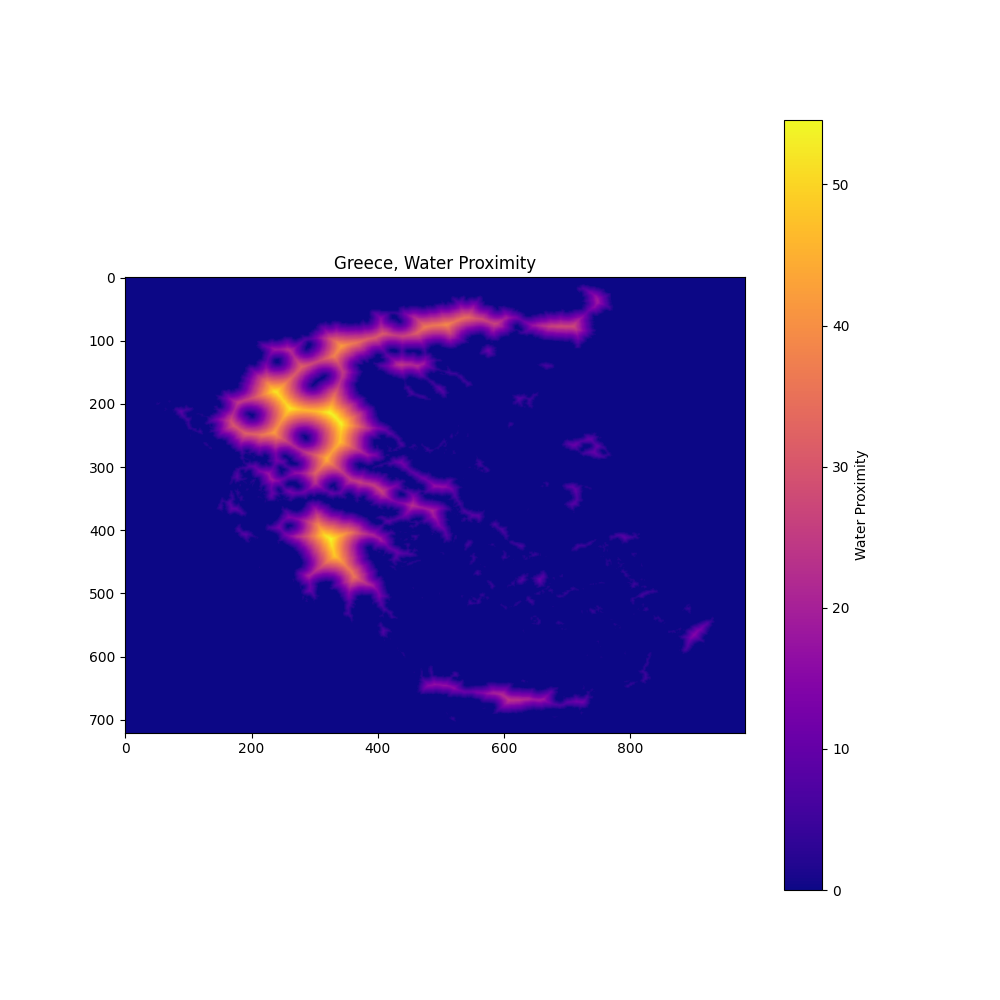

In [10]:
data = np.zeros(shape=(300,6))
indexholder = [0]

plt.figure(figsize=(10, 10))
cax = plt.imshow(comparison.pixels, cmap='plasma')
plt.colorbar(label='Water Proximity')
plt.title('Greece, Water Proximity')

cursor = mplcursors.cursor(cax, hover=False)

@cursor.connect("add")
def on_add(sel):
    x, y = sel.target.index
    val = round(comparison.pixels[x,y],4)
    x1, y1 = comparison.map(day,x,y)
    val1 = round(day.pixels[x1,y1]-273.15,4)

    if val1 > -30 and not math.isnan(val):
        if indexholder[0] < data.shape[0]:
            data[indexholder[0],0]=x
            data[indexholder[0],1]=y
            data[indexholder[0],2]=val
            data[indexholder[0],3]=x1
            data[indexholder[0],4]=y1
            data[indexholder[0],5]=val1
            indexholder[0] += 1
            sel.annotation.set_text(f'\nINDEX={indexholder[0]}')
        else:
            sel.annotation.set_text(f'DATA ARRAY IS FULL')
    else:
        sel.annotation.set_text(f'INVALID DATA! - DID NOT STORE')
    
    

plt.show()

In [ ]:
indeces = np.argsort(data[:, 5])
data = data[indeces]
coef, cov = np.polyfit(data[:,5],data[:,2],1, cov=True)
poly = np.poly1d(coef)
print(data)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data[:,5], data[:,2], color='blue', label='Pairs')
plt.plot(data[:,5], poly(data[:,5]), color='black', label='Pairs')
plt.title('Scatter Plot of Sorted Pairs')
plt.xlabel('LST')
plt.ylabel('DEM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparison.bounds.print('\n')
day.bounds.print()

In [11]:
data_full = []

for y in range(day.pixels.shape[1]):
    for x in range(day.pixels.shape[0]):
        cx,cy = day.map(comparison,x,y)
        if day.pixels[x,y] != 0 and comparison.pixels[cx, cy] > 0:
            data_full.append((day.pixels[x,y] - 273.15, comparison.pixels[cx,cy]))

data_full = np.array(data_full)

In [12]:
coef, cov = np.polyfit(data_full[:,0],data_full[:,1],1, cov=True)
poly = np.poly1d(coef)

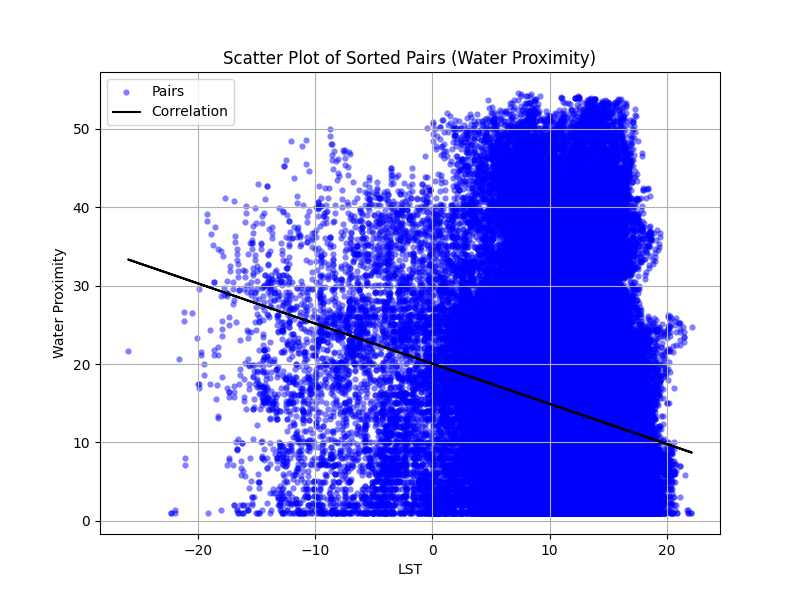

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(data_full[:,0], data_full[:,1], color='blue', label='Pairs', alpha=0.5, s=20, linewidth=0)
plt.plot(data_full[:,0], poly(data_full[:,0]), color='black', label='Correlation')
plt.title('Scatter Plot of Sorted Pairs (Water Proximity)')
plt.xlabel('LST')
plt.ylabel('Water Proximity')
plt.legend()
plt.grid(True)

plt.show()



In [15]:
coef

array([-0.51211619, 20.03809338])